In [111]:
import pandas as pd
import numpy as np
import keras
from tqdm import tqdm
import nltk

In [112]:
tweets = pd.read_csv("labeled_data.tsv", sep='\t')

In [113]:
tweets.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [114]:
tweets.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [115]:
tweets.shape

(24783, 7)

In [116]:
import string 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [117]:
def clean_statements(df):
    clean_tweets=[]
    lemma = WordNetLemmatizer()
    for sent in tqdm(df["tweet"]):
        sent  = sent.lower()
        clean_sent = sent.translate(str.maketrans('','',string.punctuation))
        words = word_tokenize(clean_sent)
        clean_word  = [word for word in words if word not in stopwords.words("english")]
        clean_words =  [lemma.lemmatize(i) for i in clean_word]
        
        clean_tweets.append(clean_words)
    
    return clean_tweets             

In [118]:
clean_tweets  = clean_statements(tweets)

100%|███████████████████████████████████████████████████████████████████████████| 24783/24783 [01:08<00:00, 364.33it/s]


In [119]:
print(len(clean_tweets))

24783


In [120]:
from keras.utils import to_categorical

In [121]:
y = tweets.offensive_language.values
y = to_categorical(y)
num_classes = y.shape[1]

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
x_train,x_test,y_train,y_test = train_test_split(clean_tweets,y,test_size=0.2,stratify=y)

In [124]:
unique_words = set()
len_max = 0

for sent in tqdm(x_train):
    unique_words.update(sent)
    
    if len_max < len(sent):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|████████████████████████████████████████████████████████████████████████| 19826/19826 [00:00<00:00, 662652.57it/s]

33157
30


In [125]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [126]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(x_train,maxlen = len_max)
x_test = sequence.pad_sequences(x_test,maxlen = len_max)

In [127]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM

In [128]:
rnn = Sequential()

rnn.add(Embedding(len(list(unique_words)),300,input_length=len_max))
rnn.add(LSTM(128,dropout=0.4,recurrent_dropout=0.4,return_sequences=True))
rnn.add(LSTM(64,dropout=0.4,recurrent_dropout=0.4,return_sequences=True))
rnn.add(LSTM(32,dropout=0.4,recurrent_dropout=0.4,return_sequences=False))
rnn.add(Dense(128,activation='relu'))
rnn.add(Dense(64,activation='relu'))
rnn.add(Dense(32,activation='relu'))
rnn.add(Dropout(0.5))
rnn.add(Dense(num_classes,activation="softmax"))

rnn.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 300)           9947100   
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 128)           219648    
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 32)               

In [129]:
history = rnn.fit(x_train,y_train,epochs=15,batch_size=64)

C:\Users\danis\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
19826/19826 [==============================] - 72s 4ms/step - loss: 1.5176 - accuracy: 0.5299
Epoch 2/15
19826/19826 [==============================] - 73s 4ms/step - loss: 1.2265 - accuracy: 0.6038
Epoch 3/15
19826/19826 [==============================] - 73s 4ms/step - loss: 1.0292 - accuracy: 0.6629
Epoch 4/15
19826/19826 [==============================] - 73s 4ms/step - loss: 0.8620 - accuracy: 0.7172
Epoch 5/15
19826/19826 [==============================] - 73s 4ms/step - loss: 0.7390 - accuracy: 0.7622
Epoch 6/15
19826/19826 [==============================] - 73s 4ms/step - loss: 0.6528 - accuracy: 0.7947
Epoch 7/15
19826/19826 [==============================] - 73s 4ms/step - loss: 0.5848 - accuracy: 0.8207
Epoch 8/15
19826/19826 [==============================] - 73s 4ms/step - loss: 0.5316 - accuracy: 0.8429
Epoch 9/15
19826/19826 [==============================] - 74s 4ms/step - loss: 0.4814 - accuracy: 0.8541
Epoch 10/15
19826/19826 [==============================

In [130]:
import matplotlib.pyplot as plt

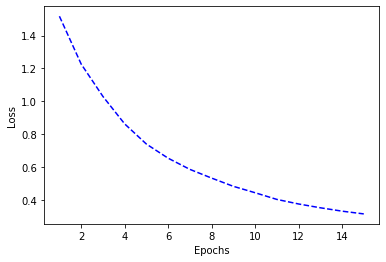

In [131]:
epoch_count = range(1,len(history.history['loss'])+1)

plt.plot(epoch_count,history.history["loss"],'b--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

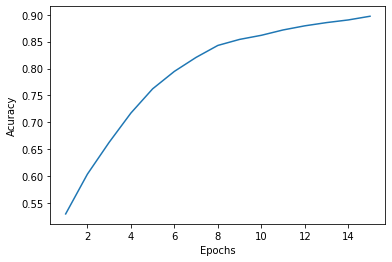

In [132]:
plt.plot(epoch_count,history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Acuracy")
plt.show()

## Prediction Using User Input Data

In [141]:
pred2 = pd.read_csv("predictions.csv",sep=',')

In [142]:
pred2.head()

,Sr No,tweet
0,1,"yo,nigga what you doing here??"
1,2,"hey,Bitch you better be ready when I come"
2,3,Hello how was you day?
3,4,"Good Morning ,isnt it a beautiful day"
4,5,you bastards can't do nothing


In [143]:
pred2 = clean_statements(pred2)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 626.69it/s]


In [144]:
pred2 = tokenizer.texts_to_sequences(pred2)
pred2 = sequence.pad_sequences(pred2,maxlen=len_max)

In [145]:
y_pred2 = rnn.predict_classes(pred2)
y_pred2

array([2, 2, 2, 0, 3], dtype=int64)